This notebook builds a movie recommendation engine use the Surprise package.
Data is downloaded from: https://grouplens.org/datasets/movielens/

Citation: F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872

Reference tutorial: https://blog.cambridgespark.com/tutorial-practical-introduction-to-recommender-systems-dbe22848392b

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import surprise
from datetime import datetime

In [2]:
# Import models from Surprise
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold

from surprise import SVDpp

### 1. Data importing, visualization and cleaning

In [3]:
# Import data
ratings = pd.read_csv('../data/ratings.csv')
movies = pd.read_csv('../data/movies.csv')
tags = pd.read_csv('../data/tags.csv')

In [4]:
from datetime import datetime

ratings.timestamp = pd.to_datetime(ratings.timestamp, unit= 's') # parse timestamp to datetime
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


In [5]:
ratings.isnull().sum() # check null values

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
tags.timestamp = pd.to_datetime(tags.timestamp, unit= 's')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,2015-10-24 19:29:54
1,2,60756,Highly quotable,2015-10-24 19:29:56
2,2,60756,will ferrell,2015-10-24 19:29:52
3,2,89774,Boxing story,2015-10-24 19:33:27
4,2,89774,MMA,2015-10-24 19:33:20


In [8]:
print('ratings',ratings.shape)
print('movies',movies.shape)
print('tags',tags.shape)

ratings (100836, 4)
movies (9742, 3)
tags (3683, 4)


### Visualizations

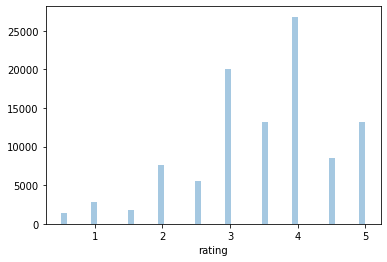

In [9]:
# Distribution of ratings
_ = sns.distplot(ratings['rating'], kde = False)
plt.show()

Most common scores are 3 and 4.

In [10]:
# Count number of ratings per movie and per user
ratings_per_movie = ratings.groupby('movieId')['movieId'].count() 
ratings_per_user = ratings.groupby('userId')['userId'].count()

In [11]:
print('Max number of ratings a movie recevied:',max(ratings_per_movie))
print('Max number of ratings a user gave:',max(ratings_per_user))

Max number of ratings a movie recevied: 329
Max number of ratings a user gave: 2698


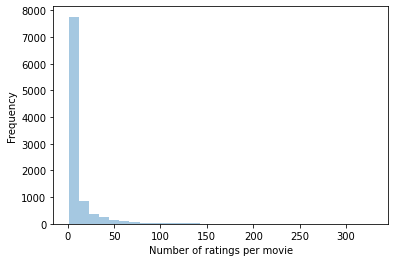

In [12]:
# Distribution of ratings 
_ = sns.distplot(ratings_per_movie, bins =30, kde = False)
plt.xlabel('Number of ratings per movie')
plt.ylabel('Frequency')
plt.show()

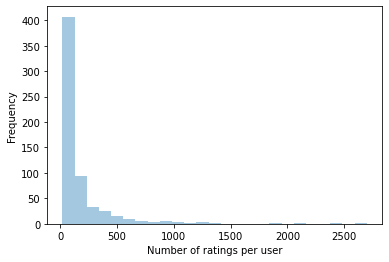

In [13]:
# Distribution of ratings
_ = sns.distplot(ratings_per_user, bins= 25, kde = False)
plt.xlabel('Number of ratings per user')
plt.ylabel('Frequency')
plt.show()

Distributions of ratings per movie and ratings per user are heavily skewed. 

To reduce dimentionality we shall remove movies that are rated less than 10 times and users that rated less than 100 movies

In [37]:
# Filter out movies rated less than 10 time, and users rated less than 100 times
filter_movieId = ratings_per_movie[ratings_per_movie > 10].index
filter_userId = ratings_per_user[ratings_per_user > 100].index

In [38]:
filtered_ratings = ratings[ratings['movieId'].isin(filter_movieId)& 
                                ratings['userId'].isin(filter_userId)]

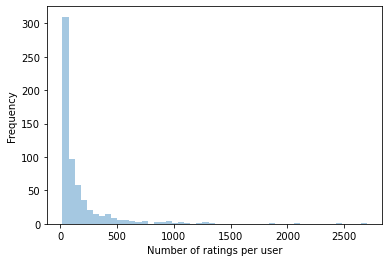

In [39]:
_ = sns.distplot(ratings_per_user, kde = False)
plt.xlabel('Number of ratings per user')
plt.ylabel('Frequency')
plt.show()

In [40]:
print('Original ratings data shape:', ratings.shape)
print('Data shape after filtering:',filtered_ratings.shape)

Original ratings data shape: (100836, 4)
Data shape after filtering: (64322, 4)


### 2. Modeling with Surprise libary

In [41]:
# Check range of ratings
print('Review rating range is {} to {}'.format(min(ratings.rating),max(ratings.rating)))

Review rating range is 0.5 to 5.0


In [42]:
filtered_ratings = filtered_ratings[['userId','movieId','rating']] # select only first three columns

In [43]:
filtered_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [44]:
# Set seed
import random
random.seed(5)
np.random.seed(5)

In [46]:
## Reformat rating range with surprise

reader = surprise.Reader(rating_scale = (0.5, 5.))
data = surprise.Dataset.load_from_df(filtered_ratings, reader)

In [47]:
# Split data into A (90%) and B (10%)
# Note: In Surprise, train_test_split does not work prior to GridSearchCV 
# Manually split datasets into trainset A and testset B.
# Ref: https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-save-some-data-for-unbiased-accuracy-estimation

raw_ratings = data.raw_ratings
threshold = int(.9 * len(raw_ratings)) # 90% train, 10% test
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]
# shuffling necessary?

In [48]:
print('Trainset lenghth:',len(A_raw_ratings))
print('Testset lenghth:',len(B_raw_ratings))

Trainset lenghth: 57889
Testset lenghth: 6433


In [49]:
data.raw_ratings = A_raw_ratings # data is now set A


#### Q: double check if train, test are correctly set

In [50]:
# Tune hyperparameters and cross validation
# Set grids for learning rate params and regularization params
print(datetime.now())
param_grid = {'lr_all': [.001, .01], 
              'reg_all': [.1, .5]}

# GridSearchCV
gs_A = GridSearchCV(surprise.SVDpp, param_grid,
                                          measures = ['rmse','mae'], cv=5)
gs_A.fit(data)
print(gs_A.best_params['rmse'])
print(datetime.now())

2020-08-31 20:19:56.465920
{'lr_all': 0.01, 'reg_all': 0.1}
2020-08-31 21:30:18.808134


In [51]:
# retrain on dataset A, with best parameters
algo = gs_A.best_estimator['rmse']

trainset = data.build_full_trainset()
algo.fit(trainset)

In [52]:
# Compute trainset accuracy
predictions = algo.test(trainset.build_testset())
print('Training accuracy:', accuracy.rmse(predictions))

# Compute testset accuracy
testset = data.construct_testset(B_raw_ratings)
predictions = algo.test(testset)
print('Testing accuracy:', accuracy.rmse(predictions))

RMSE: 0.7647
Training accuracy: 0.7647474167540812
RMSE: 0.9048
Testing accuracy: 0.9047643501651624


Model seems a bit underfitting. 

In [53]:
# Customized function to make recommendations to a selected userId
import warnings
warnings.filterwarnings('ignore')

# list of unique movieIds
iids = filtered_ratings['movieId'].unique()

def recommend_movies(userId, n_movie_rec):
    
    '''Function to take an userId and number of movies to recommend,
    and compute the top predicted-rated movies to recommend to this user '''
    
    # get list of movies that has been rated
    rated_iids = filtered_ratings.loc[filtered_ratings['userId']== userId, 'movieId']
    iids_to_pred = np.setdiff1d(iids,rated_iids)

    # Create a dataset in the same sparse form and fill ratings will 4.0
    dataset = [[userId,iid, 4.] for iid in iids_to_pred]
    predictions = algo.test(dataset)

    # Convert predictions to an array
    pred_ratings = np.array([pred.est for pred in predictions])

    # Get index of top n highest-rated movies 
    pred_ind = np.argpartition(pred_ratings, -n_movie_rec)[-n_movie_rec:]
    # sort indexes by value
    pred_ind = pred_ind[np.argsort(pred_ratings[pred_ind])]

    # convert to movie iid
    pred_movie_id = iids_to_pred[pred_ind]

    # Top n highest-rated movies to recommend
    rec = movies.loc[movies['movieId'].isin(pred_movie_id)]
    rec['pred_ratings']= pred_ratings[pred_ind].tolist()

    return rec

In [65]:
# Run a test on user 1
userId = 1
n_movie_rec =10
recs = recommend_movies(userId,10)

In [66]:
print(recs)

      movieId                                          title  \
277       318               Shawshank Redemption, The (1994)   
680       898                 Philadelphia Story, The (1940)   
694       912                              Casablanca (1942)   
704       922  Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)   
841      1104               Streetcar Named Desire, A (1951)   
883      1178                          Paths of Glory (1957)   
906      1204                      Lawrence of Arabia (1962)   
918      1217                                     Ran (1985)   
947      1248                           Touch of Evil (1958)   
7704    89904                              The Artist (2011)   

                        genres  pred_ratings  
277                Crime|Drama           5.0  
680       Comedy|Drama|Romance           5.0  
694              Drama|Romance           5.0  
704    Drama|Film-Noir|Romance           5.0  
841                      Drama           5.0  
883          

In [62]:
user_top_ratings = ratings.loc[(ratings['userId']== userId)].sort_values(
                    by= 'movieId', ascending =False).head(10)
print(user_top_ratings)

     userId  movieId  rating           timestamp
231       1     5060     5.0 2000-07-30 19:06:42
230       1     4006     4.0 2000-07-30 18:48:23
229       1     3809     4.0 2000-07-30 18:20:20
228       1     3793     5.0 2000-07-30 18:30:55
227       1     3744     4.0 2000-07-30 18:11:34
226       1     3740     4.0 2000-07-30 18:40:17
225       1     3729     5.0 2000-07-30 18:39:23
224       1     3703     5.0 2000-07-30 18:31:49
223       1     3702     5.0 2000-07-30 19:02:17
222       1     3671     5.0 2000-07-30 18:26:29


In [60]:
user_top_movies = movies.loc[movies['movieId'].isin(user_top_ratings.movieId.tolist())]
print(user_top_movies)

      movieId                                 title  \
2733     3671                Blazing Saddles (1974)   
2764     3702                        Mad Max (1979)   
2765     3703  Road Warrior, The (Mad Max 2) (1981)   
2788     3729                          Shaft (1971)   
2798     3740    Big Trouble in Little China (1986)   
2802     3744                          Shaft (2000)   
2836     3793                          X-Men (2000)   
2847     3809                What About Bob? (1991)   
2991     4006        Transformers: The Movie (1986)   
3673     5060          M*A*S*H (a.k.a. MASH) (1970)   

                                   genres  
2733                       Comedy|Western  
2764              Action|Adventure|Sci-Fi  
2765     Action|Adventure|Sci-Fi|Thriller  
2788          Action|Crime|Drama|Thriller  
2798      Action|Adventure|Comedy|Fantasy  
2802                Action|Crime|Thriller  
2836              Action|Adventure|Sci-Fi  
2847                               Comedy 

**Summary**

It seems that some long-time classic movies like Star Wars and Shawshank Redemption are being recommended very frequently. They were rated by too many users so that recommending these movies might not be very personalized choice. 

Next we may need to remove these "super movies" to improve model performance. 